In [44]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch as pt
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import transformers
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
df = pd.read_csv('train.txt')

In [18]:
print(df)

      Unnamed: 0 class                                               text
0              0   Neg   In 1992 we bought a new Taurus and we really ...
1              1   Neg   The last business trip  I drove to San Franci...
2              2   Neg   My husband and I purchased a 1990 Ford F250 a...
3              3   Neg   I feel I have a thorough opinion of this truc...
4              4   Neg   AS a mother of 3  all of whom are still in ca...
...          ...   ...                                                ...
1219        1377   Pos   In June we bought the Sony Limited Edition Fo...
1220        1378   Pos   After 140 000 miles  we decided to replace my...
1221        1379   Pos   The Ford Focus is a great little record setti...
1222        1380   Pos   I needed a new car because my hyundai excel 9...
1223        1381   Pos   The 2000 Ford Focus SE 4 door sedan has a spa...

[1224 rows x 3 columns]


In [19]:
# 1a
df.groupby("class").count().drop(["Unnamed: 0"], axis=1)

,text
class,
Neg,612
Pos,612


There are 612 positive text messages and 612 negative text messages

In [20]:
# 1b
df["text_length"] = df["text"].str.len()
print(df)

      Unnamed: 0 class                                               text  \
0              0   Neg   In 1992 we bought a new Taurus and we really ...   
1              1   Neg   The last business trip  I drove to San Franci...   
2              2   Neg   My husband and I purchased a 1990 Ford F250 a...   
3              3   Neg   I feel I have a thorough opinion of this truc...   
4              4   Neg   AS a mother of 3  all of whom are still in ca...   
...          ...   ...                                                ...   
1219        1377   Pos   In June we bought the Sony Limited Edition Fo...   
1220        1378   Pos   After 140 000 miles  we decided to replace my...   
1221        1379   Pos   The Ford Focus is a great little record setti...   
1222        1380   Pos   I needed a new car because my hyundai excel 9...   
1223        1381   Pos   The 2000 Ford Focus SE 4 door sedan has a spa...   

      text_length  
0             831  
1            1566  
2            20

In [21]:
# 2a
# We try to drop data with missing text, but there is no such data.
df = df.drop(df[df.text_length == 0].index)
df["label"] = df["class"].apply(lambda x: 1 if x == "Pos" else 0)
df

,Unnamed: 0,class,text,text_length,label
0,0,Neg,In 1992 we bought a new Taurus and we really ...,831,0
1,1,Neg,The last business trip I drove to San Franci...,1566,0
2,2,Neg,My husband and I purchased a 1990 Ford F250 a...,2063,0
3,3,Neg,I feel I have a thorough opinion of this truc...,3392,0
4,4,Neg,AS a mother of 3 all of whom are still in ca...,1599,0
...,...,...,...,...,...
1219,1377,Pos,In June we bought the Sony Limited Edition Fo...,1861,1
1220,1378,Pos,After 140 000 miles we decided to replace my...,2680,1
1221,1379,Pos,The Ford Focus is a great little record setti...,1961,1
1222,1380,Pos,I needed a new car because my hyundai excel 9...,1422,1


# 2b 
We need to tokenzier the sentence before we do anything
We can convert the text into a vector before training, but for simplicity, we train the Bert model together with the linear layer.

In [22]:
# create the class of text dataset
class TextDataset(Dataset):

    def __init__(self, messages, targets, tokenizer, max_len):
        self.messages = messages
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, item):
        text = str(self.messages[item])
        target = int(self.targets[item])

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt'
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': pt.tensor(target, dtype=pt.long)
        }

In [23]:
# Define the dataloader
df_train, df_test = train_test_split(df, test_size=0.1)
df_val, df_test = train_test_split(df_test, test_size=0.5)
df_train.text

max_len = 512
batch_size = 4
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    padding='max_length',
    model_max_length=512, 
    Trucation=True
)

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextDataset(
        messages=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )


train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)



In [24]:
# q3 Define the  model, we use a bert-base-uncased model with 
class SentimentClassifier(pt.nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.out = pt.nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        return self.out(pooled_output)

In [25]:
EPOCHS = 10
device = "cuda"

model = SentimentClassifier(2)
optimizer = pt.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = pt.nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  model = model.to(device)

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = pt.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += pt.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  model = model.to(device)

  losses = []
  correct_predictions = 0

  with pt.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = pt.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += pt.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        pt.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Ken\.conda\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/10
----------
Train loss 0.5903748342416425 accuracy 0.7020890099909173
Val   loss 0.38238796312361956 accuracy 0.8360655737704918

Epoch 2/10
----------
Train loss 0.43887626877445995 accuracy 0.8664850136239781
Val   loss 0.47961423319065943 accuracy 0.8688524590163935

Epoch 3/10
----------
Train loss 0.22072551590753248 accuracy 0.9445958219800181
Val   loss 0.6622770473768469 accuracy 0.8852459016393444

Epoch 4/10
----------
Train loss 0.12208261865062936 accuracy 0.9754768392370572
Val   loss 1.0789962846247363 accuracy 0.8524590163934427

Epoch 5/10
----------
Train loss 0.07370962042203746 accuracy 0.9881925522252497
Val   loss 1.2165836756612407 accuracy 0.8688524590163935

Epoch 6/10
----------
Train loss 0.05447819325248323 accuracy 0.9909173478655767
Val   loss 1.2898190013020212 accuracy 0.8524590163934427

Epoch 7/10
----------
Train loss 0.03593133532938183 accuracy 0.9927338782924614
Val   loss 1.3976047946107428 accuracy 0.8524590163934427

Epoch 8/10
--------

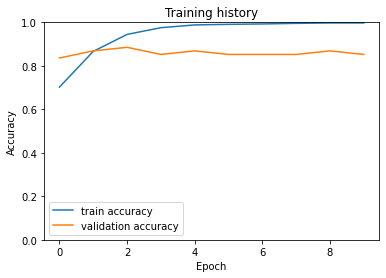

In [29]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [72]:
# accuracy of the model in the testing set
model = SentimentClassifier(2)
model.load_state_dict(pt.load('best_model_state.bin'))
model = model.to(device)
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Ken\.conda\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecate

0.7903225806451613

In [67]:
def get_predictions(model, data_loader):
    model = model.eval()
    model = model.to(device)

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with pt.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = pt.max(outputs, dim=1)

            probs = nn.functional.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = pt.stack(predictions).cpu()
    prediction_probs = pt.stack(prediction_probs).cpu()
    real_values = pt.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

In [68]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [69]:
# q4 we use precision, recall, etc... to evaluate the classification model
class_names = ["negative", "positive"]
print(classification_report(y_test, y_pred, target_names=class_names))
# precise = TP / (TP + FP)
# recall = TP / (TP + FN)

              precision    recall  f1-score   support

    negative       0.79      0.82      0.81        33
    positive       0.79      0.76      0.77        29

    accuracy                           0.79        62
   macro avg       0.79      0.79      0.79        62
weighted avg       0.79      0.79      0.79        62



In [70]:
confusion_matrix(y_test, y_pred)

array([[27,  6],
       [ 7, 22]], dtype=int64)

In [71]:
# Draw one sample and see the prediction result
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
prob, pred = pt.max(y_pred_probs[idx], dim=0)
pred = "negative" if pred == 0 else 1

print(review_text)
print()
print(f"prediction: {pred} with probability {prob}")
print(f'True sentiment: {class_names[true_sentiment]}')

 my ford focus had some of the same problems as volvinator  quot this car sucks quot  namely the leak and the brake problem  i ve had it in for the brakes twice and now they tell me that because of the high metal content in the brake pads the squeaking is unavoidable  i ve called customer no care and they have been unhelpful even with the best of intentions  i too am facing the 12 000 mile deadline  and one simply incompetent customer service agent even suggested that i just not drive the car so that i don t break the 12k barrier and all my repairs would be covered when the brake pad is developed  when will that be  next week  next month  or next year  she couldn t answer that question  at the mailbox this evening i met another focus owner who has the cruise control problem where if you put it into cruise the car gets a mind of its own and starts speeding away  she also is having the brake problem  and since she has power locks she has one door that refuses to lock when she presses the

5a. I choose this model because Bert model is a powerful pretrained model for multiple natural language processing tasks, whether is upstream or downstream. Basically speaking, for any natural language processing tasks, one can try out Bert model to see the performance. I only add a linear layer after the Bert model to make my model output a valid probablity.

5b. Accuracy, precision, recall , F1-score

5c. The bert model can handle sentence with length at most 512, everything longer than that will be truncated. That will make our model blind to long sentence. My model also use a cross entropy loss to train, which may be affected by random noise. 

5d. One can try to break the longer sentence into multiple chunks and use some bagging ideas to handle a longer sentence. Or one can also try a more powerful model like GPT-3 to model to sentiment. For the loss function, one can also try to use hinge loss to make the model more robust to noise. Actually, the code contains boilerplate which can be simplified by using another framework called pytorch-lightning.